In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigsh
import scipy as sps

#define constant

omega  = 110.7          #mev
d      = 1.420          #angstrom, whatever is ok.
hv     = 1.5*d*2970     #meV*angstrom, Fermi velocity for SLG
N      = 15              #truncate range
valley = 1             #+1 for K, -1 for K'
KDens  = 100            #density of k points, 100 is good.

#tune parameters

I      = complex(0, 1)
ei120  = np.cos(2*np.pi/3) + valley*I*np.sin(2*np.pi/3)
ei240  = np.cos(2*np.pi/3) - valley*I*np.sin(2*np.pi/3)



Tqb    = omega*np.array([[1,1], [1,1]], dtype=complex)
Tqtr   = omega*np.array([[ei120, 1], [ei240, ei120]], dtype=complex)
Tqtl   = omega*np.array([[ei240, 1], [ei120, ei240]], dtype=complex)
TqbD   = np.array(np.matrix(Tqb).H)
TqtrD  = np.array(np.matrix(Tqtr).H)
TqtlD  = np.array(np.matrix(Tqtl).H)

#define Lattice
L = []
invL = np.zeros((2*N+1, 2*N+1), int)

def Lattice(n):
    count = 0
    for i in np.arange(-n, n+1):
        for j in np.arange(-n, n+1):
            L.append([i, j])
            invL[i+n, j+n] = count
            count = count + 1
    for i in np.arange(-n, n+1):
        for j in np.arange(-n, n+1):
            L.append([i, j])

Lattice(N)
siteN = (2*N+1)*(2*N+1)
L = np.array(L)

levels = 60


def Hamiltonian(kx, ky, theta):
    
    theta  = theta/180.0*np.pi 
    b1m    = 8*np.pi*np.sin(theta/2)/3/d*np.array([0.5, -np.sqrt(3)/2])
    b2m    = 8*np.pi*np.sin(theta/2)/3/d*np.array([0.5, np.sqrt(3)/2])
    qb     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([0, -1])
    K1     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([-np.sqrt(3)/2,-0.5])
    K2     = 8*np.pi*np.sin(theta/2)/3/np.sqrt(3)/d*np.array([-np.sqrt(3)/2,0.5])
    H = np.array(np.zeros((4*siteN, 4*siteN)), dtype=complex)
    
    for i in np.arange(siteN):
        #diagonal term
        ix = L[i, 0]
        iy = L[i, 1]
        ax = kx - valley*K1[0] + ix*b1m[0] + iy*b2m[0]
        ay = ky - valley*K1[1] + ix*b1m[1] + iy*b2m[1]

        qx = np.cos(theta/2) * ax + np.sin(theta/2) * ay
        qy =-np.sin(theta/2) * ax + np.cos(theta/2) * ay
         
        H[2*i, 2*i+1] = hv * (valley*qx - I*qy)
        H[2*i+1, 2*i] = hv * (valley*qx + I*qy)

        #off-diagonal term
        j = i + siteN
        H[2*j, 2*i]     = TqbD[0, 0]
        H[2*j, 2*i+1]   = TqbD[0, 1]
        H[2*j+1, 2*i]   = TqbD[1, 0]
        H[2*j+1, 2*i+1] = TqbD[1, 1]
        if (iy != valley*N):
            j = invL[ix+N, iy+valley*1+N] + siteN
            H[2*j, 2*i]     = TqtrD[0, 0]
            H[2*j, 2*i+1]   = TqtrD[0, 1]
            H[2*j+1, 2*i]   = TqtrD[1, 0]
            H[2*j+1, 2*i+1] = TqtrD[1, 1]
        if (ix != -valley*N):
            j = invL[ix-valley*1+N, iy+N] + siteN
            H[2*j, 2*i]     = TqtlD[0, 0]
            H[2*j, 2*i+1]   = TqtlD[0, 1]
            H[2*j+1, 2*i]   = TqtlD[1, 0]
            H[2*j+1, 2*i+1] = TqtlD[1, 1]
        

    for i in np.arange(siteN, 2*siteN):
        #diagnoal term
        j = i - siteN
        ix = L[j, 0]
        iy = L[j, 1]
        ax = kx  - valley*K2[0] + ix*b1m[0] + iy*b2m[0] 
        ay = ky  - valley*K2[1] + ix*b1m[1] + iy*b2m[1]

        qx = np.cos(theta/2) * ax - np.sin(theta/2) * ay
        qy = np.sin(theta/2) * ax + np.cos(theta/2) * ay

        H[2*i, 2*i+1] = hv * (valley*qx - I*qy)
        H[2*i+1, 2*i] = hv * (valley*qx + I*qy)

        #off-diagonal term
        H[2*j, 2*i]     = Tqb[0, 0]
        H[2*j, 2*i+1]   = Tqb[0, 1]
        H[2*j+1, 2*i]   = Tqb[1, 0]
        H[2*j+1, 2*i+1] = Tqb[1, 1]
        if (iy != (-valley*N)):
            j = invL[ix+N, iy-valley*1+N]
            H[2*j, 2*i]     = Tqtr[0, 0]
            H[2*j, 2*i+1]   = Tqtr[0, 1]
            H[2*j+1, 2*i]   = Tqtr[1, 0]
            H[2*j+1, 2*i+1] = Tqtr[1, 1]
        if (ix != valley*N):
            j = invL[ix+valley*1+N, iy+N]
            H[2*j, 2*i]     = Tqtl[0, 0]
            H[2*j, 2*i+1]   = Tqtl[0, 1]
            H[2*j+1, 2*i]   = Tqtl[1, 0]
            H[2*j+1, 2*i+1] = Tqtl[1, 1]


    eigensystem = sps.sparse.linalg.eigsh(H, k = levels, which = "SM")
    
    return eigensystem
            
sigma = np.array(np.zeros((4*siteN, 4*siteN)), dtype=complex)

for i in np.arange(2*siteN):
        sigma[2*i, 2*i+1] = 1
        sigma[2*i+1, 2*i] = 1
        
f = np.array(np.zeros((levels), dtype=int))

for i in np.arange(int(levels/2)):
    f[i] = 1
    
eta = 3 # broadening of resonances in meV

def DinamCond(theta, en):
    
    # returns sigma_xx/sigma_mono following Moon Koshino (2013)
    # the output has dimensions 1/angstrom^2. all energies are treated in meV.
    
    eig_vec = Hamiltonian(0,0,theta)
    sorted_eig_ens = np.sort(eig_vec[0])
    sorted_eig_vec = []
    argsort = eig_vec[0].argsort(axis=None)
    for i in np.arange(levels):
        sorted_eig_vec.append(eig_vec[1][:,np.where(argsort==i)])
    sorted_eig_vec = np.array(sorted_eig_vec)
    sorted_eig_vec = np.squeeze(sorted_eig_vec)
    
    sigma_xx = 0
    for i in np.arange(levels):
        for j in np.arange(levels):
                if i!=j:
                    matrix_element = np.abs(np.dot(sorted_eig_vec[i], np.matmul(sigma, sorted_eig_vec[j])))
                    Ei = sorted_eig_ens[i]
                    Ej = sorted_eig_ens[j]
                    sigma_xx += (f[i]-f[j])*4*hv**2/(Ei-Ej+1.j*eta)*matrix_element**2/(Ei-Ej+en+1.j*eta)
                
#               sigma_xx += (f[i]-f[j])*4*hv**2/(en)*matrix_element**2/(Ei-Ej+en+1.j*eta)
    return sigma_xx/1.j

In [16]:
Hamiltonian(0,0,5)

(array([ -723.55042937,   713.07858558, -1151.50532348,  1160.35790543,
          734.04311903,  -737.46745766,  -737.46745766,   734.04311903,
        -1127.75256502, -1127.75256502,  1129.58136775,  1129.58136775,
         1837.46811593,  1837.60641561,  1843.14817498,  1843.24950114,
        -1838.18934857, -1843.70237889, -1843.69913784, -1838.25520436,
        -1838.25520436, -1843.69913784,  1843.14817498,  1837.60641561,
        -2267.32556405, -2267.32752126, -2267.32752126,  2265.43154413,
        -2524.0897678 , -2526.26319461, -2700.11858518, -2526.63671937,
        -2523.72264137, -2523.72264137, -2526.63671937, -2700.11463096,
        -2700.11463096,  2265.43762815,  2265.43762815,  2528.73288848,
         2523.01020677,  2701.83455769,  2701.82696625,  2529.07377924,
         2529.07377924,  2522.67714397,  2522.67714397,  2701.82696625,
        -3297.92949807, -3297.92948297, -3302.24869672, -3302.2486823 ,
        -3297.92949807, -3302.2486823 , -3368.68112552, -3368.70

In [8]:
DinamCond(5,500)

(0.6003564247166977-46.92008755441373j)

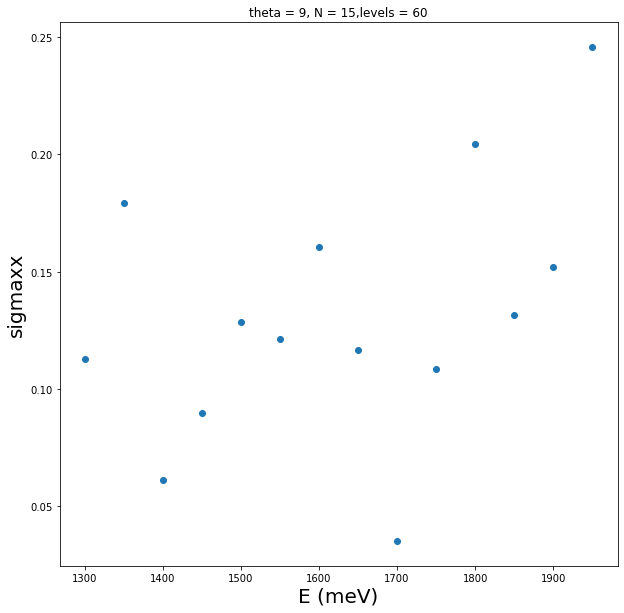

In [30]:
dinam_conds = []
imag_conds = []

Num = 14
angle = 9

for i in range(Num):
    en = 1300 + 50*i
    dinam_conds.append([en, np.real(DinamCond(angle, en))])
    imag_conds.append([en, np.imag(DinamCond(angle, en))])

dinam_conds
x, y = np.array(dinam_conds).T

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.ylabel('sigmaxx', fontsize=20)
plt.xlabel('E (meV)', fontsize=20)
plt.title( "theta = " + str(angle) + ", N = " + str(N) + ",levels = " + str(levels) )
plt.show()

In [31]:
dinam_conds

[[1300, 0.11301470742429941],
 [1350, 0.17937859855283808],
 [1400, 0.0614173354833207],
 [1450, 0.08963571604668549],
 [1500, 0.1285276146597269],
 [1550, 0.12112979289089013],
 [1600, 0.16046031938051572],
 [1650, 0.11670116102467458],
 [1700, 0.03518393550518082],
 [1750, 0.10843599137442173],
 [1800, 0.20446552141186733],
 [1850, 0.1317567902678599],
 [1900, 0.1521735221864947],
 [1950, 0.2458420214393776]]

In [ ]:
conds5 = [[1300, 5.252293660975694],
 [1350, 4.567598569476645],
 [1400, 0.4252526265390444],
 [1450, 66.88617808939239],
 [1500, 15.164060582092022],
 [1550, 9.544643217487637],
 [1600, 28.112304188254807],
 [1650, 11.258421104179085],
 [1700, 0.7184946340665195],
 [1750, 3.7433492099038554],
 [1800, 247.06503037593512],
 [1850, 52.18708641445488],
 [1900, 88.35346941812196],
 [1950, 24.232192223650273]]

conds6 = [[1300, 0.9384140448998127],
 [1350, 0.8040657660542087],
 [1400, 0.6021185488020895],
 [1450, 1.3267543588647717],
 [1500, 1.1291545518951116],
 [1550, 0.5823801656695216],
 [1600, 2.008763606582156],
 [1650, 5.389850579716519],
 [1700, 0.3382483691621822],
 [1750, 1.0370490768969693],
 [1800, 22.32195881659115],
 [1850, 3388.6791583248346],
 [1900, 54.95756112434922],
 [1950, 18.15984309056459]]

conds7 = [[1300, 0.3821868143780454],
 [1350, 0.15546631545310902],
 [1400, 0.2586911987866697],
 [1450, 0.3265806733935792],
 [1500, 0.4972373188660809],
 [1550, 0.5153226137705862],
 [1600, 0.5760045541992608],
 [1650, 0.5913816699135684],
 [1700, 0.573244531601561],
 [1750, 0.665600538927251],
 [1800, 0.6444337213070291],
 [1850, 0.3289396821581938],
 [1900, 0.157306370087672],
 [1950, 1.8410358902945279]]

iconds7 = [[1300, -40.45874532929643],
 [1350, -48.537821530384576],
 [1400, -70.1946055779434],
 [1450, -65.19993695865664],
 [1500, -35.96621904023795],
 [1550, -50.30220224476713],
 [1600, -95.33943743865744],
 [1650, -102.29231436479017],
 [1700, -31.971923313118054],
 [1750, -56.894588326593016],
 [1800, -136.85652241289847],
 [1850, -220.4840390280082],
 [1900, -76.26264698285932],
 [1950, -140.57247367607246]]

conds8 = [[1300, 0.1656248299773867],
 [1350, 0.22267677832574234],
 [1400, 0.2609075331964035],
 [1450, 0.10989313632097907],
 [1500, 0.13989813027703252],
 [1550, 0.2326159092624772],
 [1600, 0.2694335318202795],
 [1650, 0.4196392721833071],
 [1700, 0.37612641899279586],
 [1750, 0.4046575846012994],
 [1800, 0.4180688426882078],
 [1850, 0.5333383897629719],
 [1900, 0.3273348017468678],
 [1950, 0.3789225046449524]]

iconds8 = [[1300, -28.030108792748063],
 [1350, -25.73116143141427],
 [1400, -44.974962429632086],
 [1450, -39.30927875654269],
 [1500, -38.454854646765824],
 [1550, -31.452334760352336],
 [1600, -53.82262143250215],
 [1650, -59.446460666748074],
 [1700, -24.440438555910056],
 [1750, -75.9549817901958],
 [1800, -48.21727388435952],
 [1850, -73.18396348333972],
 [1900, -69.48944118749955],
 [1950, -61.72383226310177]]

conds9 = [[1300, 0.11301470742429941],
 [1350, 0.17937859855283808],
 [1400, 0.0614173354833207],
 [1450, 0.08963571604668549],
 [1500, 0.1285276146597269],
 [1550, 0.12112979289089013],
 [1600, 0.16046031938051572],
 [1650, 0.11670116102467458],
 [1700, 0.03518393550518082],
 [1750, 0.10843599137442173],
 [1800, 0.20446552141186733],
 [1850, 0.1317567902678599],
 [1900, 0.1521735221864947],
 [1950, 0.2458420214393776]]

iconds9 = [[1300, -16.473418658208278],
 [1350, -14.914364221944048],
 [1400, -31.875643449760158],
 [1450, -29.920597170180432],
 [1500, -29.231716539482225],
 [1550, -44.9606368737315],
 [1600, -46.79056718141437],
 [1650, -36.828395965227365],
 [1700, -34.11004932168901],
 [1750, -26.626888968258505],
 [1800, -32.6709783126259],
 [1850, -44.77490626193301],
 [1900, -65.86337683226223],
 [1950, -46.15128881044951]]

In [32]:
imag_conds

[[1300, -16.473418658208278],
 [1350, -14.914364221944048],
 [1400, -31.875643449760158],
 [1450, -29.920597170180432],
 [1500, -29.231716539482225],
 [1550, -44.9606368737315],
 [1600, -46.79056718141437],
 [1650, -36.828395965227365],
 [1700, -34.11004932168901],
 [1750, -26.626888968258505],
 [1800, -32.6709783126259],
 [1850, -44.77490626193301],
 [1900, -65.86337683226223],
 [1950, -46.15128881044951]]